# <center>Deepfake Image Detection Using CNN + SVM</center>
**<center>李文萱</center>**

## Introduction

In this code, my goal is to detect deepfake images using the machine learning technique of support vector machines (SVM). We divide the whole process into two parts:     
1. Extract features from images using a transfer learning strategy by using a pre-trained CNN model (VGG16).     
2. Complete the training of the SVM model with the data after feature extraction and the corresponding label.   

The model framework is shown in the following figure:
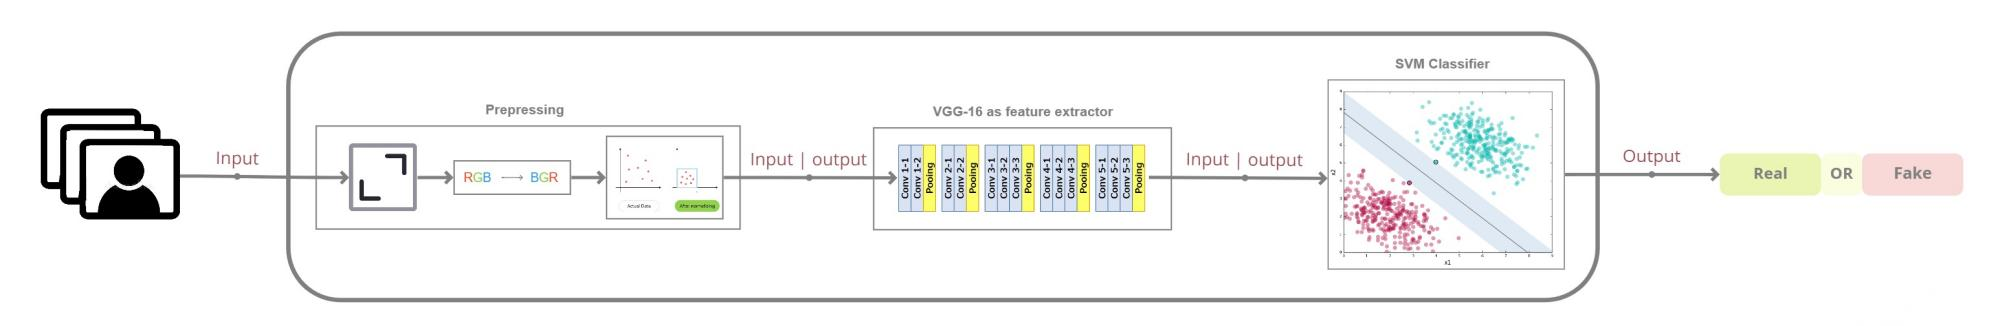

So far, we have completed the SVM model that can be used for deepfake image detection. When using this model for prediction, the input picture still needs to be extracted by the VGG16 model before it can be input into the SVN model to complete the prediction.

## Data Set

The dataset we use is from kaggle. The dataset includes high-quality deepfake images obtained by styleGAN. The full dataset contains a total of 4 GB with a total of 140,000 images. We sampled 2000 images from each of the 'fake' and 'real' categories, for a total of 4000 images, as our dataset. In the subsequent training and testing, we divide the dataset into training set and testing set according to the ratio of 8:2.

**Dataset Resouces: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces.**

## 1. Import Resources

In [1]:
# NumPy: A Python library used for convert list to arrays
import numpy as np

# plt: Module that import names for the opencv-python library to solve computer vision problems.
import matplotlib.pyplot as plt 

# glob: Module to return all file paths matching in a folder
import glob 

# cv2: Import names for the opencv-python library for computer vision problems
import cv2 
 
# pd: Package for data analysis and manipulation tools
import pandas as pd 

# BatchNormalization: The technique used in training
from tensorflow.keras.layers import BatchNormalization  

# os: Modules provide functionality for working with folders
import os 

# sns: Data visualization library
import seaborn as sns 

# VGG16: The CNN technique used for feature extraction
from keras.applications.vgg16 import VGG16 

# SVC: Used to classify images
from sklearn.svm import SVC 

# GridSearchCV: The library for building and training SVCs with hyperparameters
from sklearn.model_selection import GridSearchCV 

# make_scorer: Function to get GridSearchCV score
from sklearn.metrics import make_scorer 

# Function used to get the evaluation metric of the classification model
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

# confusion_matrix,ConfusionMatrixDisplay: Handling and Displaying Confusion Matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# joblib: The tool for saving models for deployment
import joblib 

# random: The tool for getitng random number
import random

# Ignore the warnings we meet
import warnings
warnings.filterwarnings("ignore")

# Set the basic style of plot
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

## 2. Preparing the data

### 2.1 Loading the data

In [2]:
# Set the absolute work path
path = 'D:/jupyter-notebook/'
os.chdir(path)

# Set relative working path
real = 'real_and_fake_face/training/real/'
fake = 'real_and_fake_face/training/fake/'

#to get the list of all real images
real_path = os.listdir(real) 

#to get the list of all fake images
fake_path = os.listdir(fake)

In [3]:
# Declare a list for images path
image_path = [] 
# Declare a list for images label (fake/real)
image_label = []

# Use loop to get the label (fake/real) of all images in the dataset
for directory_path in glob.glob('real_and_fake_face/training/*'):
    
    # Loading the image label
    # Because the path is 'real_and_fake_face\\training_real' (Example)
    # Split the string to get exactly class
    label = directory_path.split("\\")[-1] 
    
    # Use loop to load images path and corresponding label into list 
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #add image path into image_path list 
        image_path.append(img_path)
        
        #add image label into image_label list  
        image_label.append(label)

# Build a dataframe of dataset         
dataset = pd.DataFrame(data=list(zip(image_path, image_label)), columns=['imagename', 'class'], index=None)

### 2.2 Exploring the data

In [4]:
# We have a total of 2041 images
print('The shape of data set is: ',dataset.shape)
dataset

The shape of data set is:  (4000, 2)


,imagename,class
0,real_and_fake_face/training\fake\001DDU0NI4.jpg,fake
1,real_and_fake_face/training\fake\00AUP94LQS.jpg,fake
2,real_and_fake_face/training\fake\00B4R41FLE.jpg,fake
3,real_and_fake_face/training\fake\00C64W8TYZ.jpg,fake
4,real_and_fake_face/training\fake\00CB415UQ7.jpg,fake
...,...,...
3995,real_and_fake_face/training\real\02762.jpg,real
3996,real_and_fake_face/training\real\02764.jpg,real
3997,real_and_fake_face/training\real\02765.jpg,real
3998,real_and_fake_face/training\real\02766.jpg,real


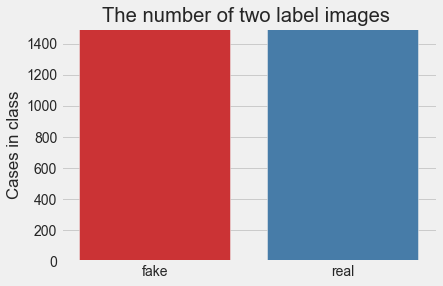

In [5]:
# Check the distribution of the target variable (is the data balanced)
df = pd.DataFrame (image_label, columns = ['target'])

# Create a bar chart of the number of examples per class
sns.countplot(x='target',data=df, palette="Set1")
plt.ylim(0, 1500)

#set the title
plt.xlabel('')
plt.ylabel('Cases in class')
plt.title('The number of two label images ')

#show the chart
plt.show()

In [6]:
def load_img(path):
    '''
    func: The function used to load the image 
          according to the input path
    
    Input: 
          path: The path to the image we want to load
    
    Output:
          The image in the input path
    
    '''
    # Load the image according to the input path
    image = cv2.imread(path)
    
    # Check if the method returns an empty matrix.
    if image is None:
        print('Wrong path:', path)
    else:
        # If the image is successfully read, reset the size of the image to (224, 224)
        image = cv2.resize(image, (224, 224))
        
    #return the image 
    return image[...,::-1]

def display(start_path, end_path, title):
    '''
    func: Used to display 16 images of the corresponding type
    
    Input: 
          start_path: The path to the folder where the images are located
          end_path  : The file name of the image (specific path)
          title     : The title of the output image
    
    Output:
          The display of 16 images under the corresponding path
    
    '''
    # Set the size of the canvas  
    fig = plt.figure(figsize=(10, 10))
    
    # Use for-loop to print 16 images 
    for i in range(16):
        
        #show the images in 4×4 display and incerment i
        plt.subplot(4, 4, i + 1)
        
        n = random.randint(0, len(end_path) - 1)
        
        # Call the load_img() function to get the image and show it 
        plt.imshow(load_img(start_path + end_path[n]), cmap='gray')
        
        # Set the title of plot
        plt.suptitle(title, fontsize=20)
        
        #set the axis propreties of graph 
        plt.axis('off')
    plt.savefig(title,dpi = 300)

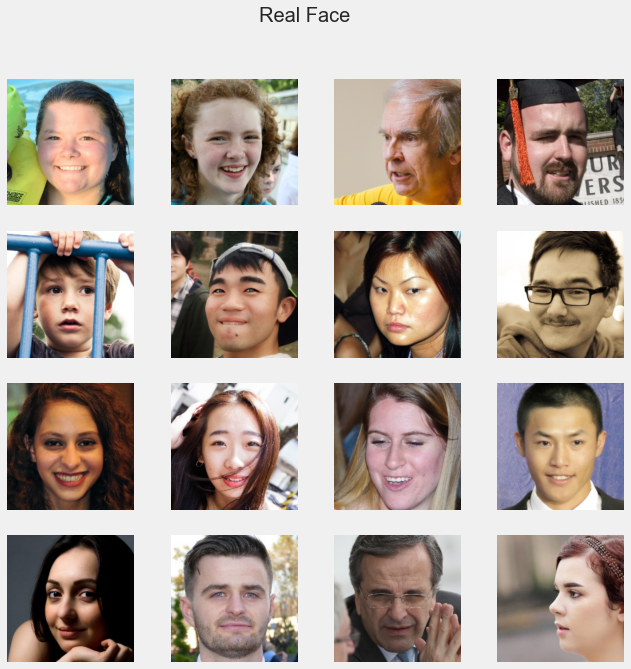

In [7]:
#To explore the dataset display sample of real image 
display(real, real_path, 'Real Face')

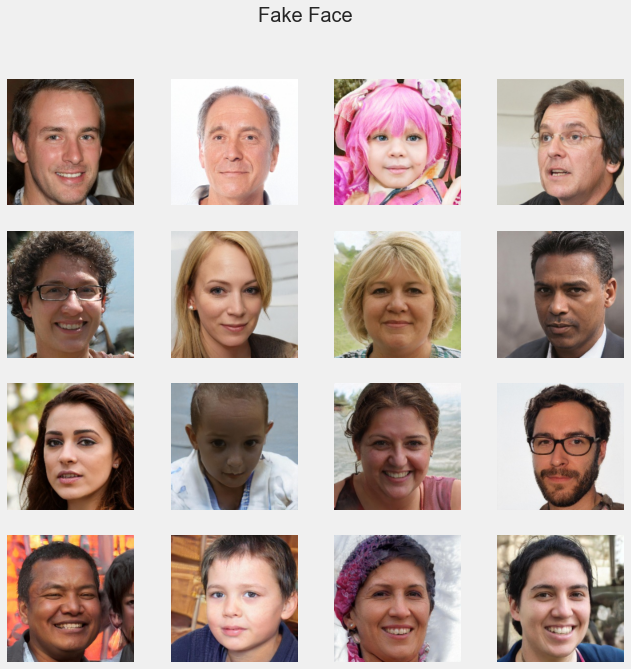

In [8]:
#To explore the dataset display sample of fake image 
display(fake, fake_path, 'Fake Face')

### 2.3 Preprocess the data

In [9]:
# Set a global variable to facilitate subsequent resize images
SIZE = 224

# Split data and labels into their own lists
# Declare a list for images
images = []
# Declare a list for images label
labels = [] 

# loop for get the label (fake/real)
for directory_path in glob.glob(path + "real_and_fake_face/training/*"):
    
    # Get the image label
    label = directory_path.split("\\")[-1] 
    
    # Use for-loop to preprocess the images
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        
        # Load image from its file and specify load color image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  
        
        # Resize all photos to the same size  
        img = cv2.resize(img, (SIZE, SIZE)) 
        
        # Normalization
        img = img / 255.0 
        
        # Add images and image tags to the corresponding lists
        images.append(img)
        labels.append(label) 

# Convert list to array     
images = np.array(images)
labels = np.array(labels)

In [10]:
# Transformations applied to our data before feeding it into the model
from sklearn import preprocessing

# Label from text to integer
# Class names 1:real and 0:fake
le = preprocessing.LabelEncoder()

#Fit the label encoder
le.fit(labels)

# Fit and transform the labels at once
labels_encoded = le.transform(labels)

### 2.4 Splitting the data into train and test

In [11]:
#train_test_split : splitting dataset into two subsets: for training data and for testing data.
from sklearn.model_selection import train_test_split

# Split the data into training and test datasets in a ratio of 8:2
# X: images
# y: labels
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, train_size=0.8)

#give the number of row (sample), the size and number of colums in trianing set and test set 
print(X_train.shape)
print(X_test.shape)

(3200, 224, 224, 3)
(800, 224, 224, 3)


## 3. Model Development

### 3.1 Feature Extraction By Using VGG16

* Load the VGG16 Pre-trained Model

In [12]:
# Load a VGG16 model without a classifier/fully connected layer to use as a feature extractor
# Hand off the classification task to another model (SVM)
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Make the loaded layer untrainable. Using pretrained weights in our task
for layer in VGG_model.layers:
	layer.trainable = False

In [13]:
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

* Extract Features By Using VGG16

In [14]:
# Extract features from images (training dataset) using pretrained VGG16.
# VGG16 expects to rescale the color input image to the size of a 224×224 square
feature_extractor = VGG_model.predict(X_train)

# Change the shape of the extracted features to the shape required by the SVM input data.
# The shape required by the SVM is two-dimensional (number of rows, number of columns)
# The number of rows is the number of images (training data) that VGG16 extracts from its features
# We can get the number of rows by the first index in the feature shape extracted by VGG16
#    and get the number of columns after reshaping the extracted features
X_train_features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [15]:
feature_extractor[0].shape

(7, 7, 512)

In [16]:
X_train_features[0].shape

(25088,)

* Save the output (extracted features) to use it as input to the SVM classifier

In [17]:
# This is the X that can be input into SVM after feature extraction
X_for_SVM = X_train_features

# Rows: Number of images
# columns: Number of extracted features per image
print(X_for_SVM.shape)

(3200, 25088)


### 3.2 Deepfake classification using SVM    
Build and Train SVM without Hyperparameter Tuning

In [18]:
# Build an SVM with default parameters and set random states to keep the same results in each run
SVM_model = SVC(random_state = 42)

# Train SVM using training data (X = extracted features: y = label)
SVM_model.fit(X_for_SVM, y_train)

SVC(random_state=42)

## 4. Model Evaluation
The parameters used by the established SVC model are all default parameters, there is no hyperparameter tuning.

* Make predictions based on tarin/test data

In [19]:
# Extract features from images (test dataset) using pretrained VGG16
# And reshape the resut to the data can be input SVM model
X_test_feature = VGG_model.predict(X_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

###### Make predction on train dataset ######
y_train_pred = SVM_model.predict(X_train_features)

# Inverse le transform to get original labels (fake or real)
# Because we trained the SVM on integer labels (0 or 1)
y_train_predd = le.inverse_transform(y_train_pred)
y_trainn = le.inverse_transform(y_train) 


###### Make predction on test dataset ######
y_test_pred = SVM_model.predict(X_test_features)

# Inverse le transform to get original labels (fake or real)
# Because we trained the SVM on integer labels (0 or 1)
y_test_predd = le.inverse_transform(y_test_pred)
y_testt = le.inverse_transform(y_test) 

* Calculate the Accuracy, Precision, Recall and F1 score on train and test data

In [20]:
# Calculate each evaluation metric in train and test predictions
# Why predict traning set: Check for overfitting and underfitting

# Generate the frame of actual and prediction result
pred = pd.DataFrame(y_train_predd)
actual = pd.DataFrame(y_trainn)
result = pd.merge(pred, actual,  how='outer', left_index=True, right_index=True)
result.columns = ['Pred', 'Actual']

# Calculate each evaluation metric in test prediction
TP = result.Pred[(result['Actual'] == 'fake') & (result['Pred'] == 'fake')].count()
FN = result.Pred[(result['Actual'] == 'fake') & (result['Pred'] == 'real')].count()
FP = result.Pred[(result['Actual'] == 'real') & (result['Pred'] == 'fake')].count()
TN = result.Pred[(result['Actual'] == 'real') & (result['Pred'] == 'real')].count()

Accuracy = (TP + TN) / (TP + FP + TN + FN)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_score = (2 * Precision * Recall) / (Precision + Recall)

# Print the result
print('-----------------------------------------------------------------')
print('Predicting Training Set Results Using SVM Model With Tunning')
print('\tAccuracy: '+ str(Accuracy))
print('\tPrecision: ' + str(Precision))
print('\tRecall: ' + str(Recall))
print('\tF1 Score: ' + str(F1_score))

-----------------------------------------------------------------
Predicting Training Set Results Using SVM Model With Tunning
	Accuracy: 0.8234375
	Precision: 0.8093525179856115
	Recall: 0.8453350031308704
	F1 Score: 0.8269525267993874


In [21]:
# Why predict test set:    Test the generalization ability of the model

# Generate the frame of actual and prediction result
pred = pd.DataFrame(y_test_predd)
actual = pd.DataFrame(y_testt)
result = pd.merge(pred, actual,  how='outer', left_index=True, right_index=True)
result.columns = ['Pred', 'Actual']

# Calculate each evaluation metric in test prediction
TP = result.Pred[(result['Actual'] == 'fake') & (result['Pred'] == 'fake')].count()
FN = result.Pred[(result['Actual'] == 'fake') & (result['Pred'] == 'real')].count()
FP = result.Pred[(result['Actual'] == 'real') & (result['Pred'] == 'fake')].count()
TN = result.Pred[(result['Actual'] == 'real') & (result['Pred'] == 'real')].count()

Accuracy = (TP + TN) / (TP + FP + TN + FN)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_score = (2 * Precision * Recall) / (Precision + Recall)

# Print the result
print('-----------------------------------------------------------------')
print('Predicting Test Set Results Using SVM Model With Tunning')
print('\tAccuracy: '+ str(Accuracy))
print('\tPrecision: ' + str(Precision))
print('\tRecall: ' + str(Recall))
print('\tF1 Score: ' + str(F1_score))

-----------------------------------------------------------------
Predicting Test Set Results Using SVM Model With Tunning
	Accuracy: 0.7725
	Precision: 0.7540229885057471
	Recall: 0.8138957816377171
	F1 Score: 0.7828162291169452


* Draw the Confusion Matrix

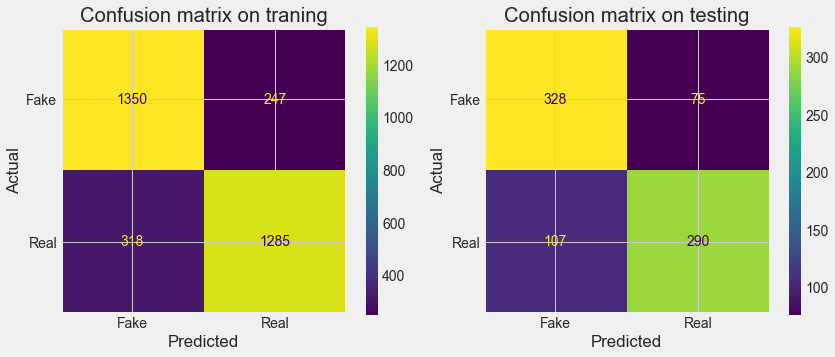

In [22]:
# Draw the confusion Matrix

fig = plt.figure(figsize = (12,5))
layout = (1,2)

confusion_trainning = plt.subplot2grid(layout,(0,0))
confusion_test = plt.subplot2grid(layout,(0,1))

# Build a confusion matrix for label predictions in the training dataset
cm = confusion_matrix(y_trainn, y_train_predd)

# Build a display object that displays a confusion matrix with corresponding label names
cmd = ConfusionMatrixDisplay(cm, display_labels=['Fake','Real'])

# Plot a confusion matrix with titles and axis names
cmd.plot(ax = confusion_trainning)
cmd.ax_.set_title("Confusion matrix on traning")
cmd.ax_.set(xlabel='Predicted', ylabel='Actual')

# Build a confusion matrix for label predictions in the test dataset
cm = confusion_matrix(y_testt, y_test_predd)

# Build a display object that displays a confusion matrix with corresponding label names
cmd = ConfusionMatrixDisplay(cm, display_labels=['Fake','Real'])

# Plot a confusion matrix with titles and axis names
cmd.plot(ax = confusion_test)
cmd.ax_.set_title("Confusion matrix on testing")
cmd.ax_.set(xlabel='Predicted', ylabel='Actual')


# Show the Confusion Matrix
plt.tight_layout()
plt.savefig('Confusion matrix without tuning', dpi = 300)
plt.show()

## 5. Model Improvement

Build and Train SVM with Hyperparameter Tuning using GridSearchCV

In [23]:
# Define common hyperparameter value ranges for SVM models
# Hyperparameter: 
#     C:      Degree of correct classification. 
#             (higher C value means smaller margins = fewer misclassifications)
#     kernel: The type of hyperplane used to separate the data 
#             ('linear' = linear hyperplane, rbf' = nonlinear hyperplane)
#     gamma:  A parameter of 'rbf' indicating how well the model fits the training data
#             If the gamma value is too high, it is easy to cause the model to overfit

param_grid = [{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']},
              {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}]

# Define the scoring method using make_scorer()
# We chose the accuracy score in order to improve the accuracy of prediction
scorer = make_scorer(accuracy_score) 

# Parameters in GridSearchCV() function: 
#     SVM():      Model without parameter values
#     param_grid: list of parameters of the model and their range of values
#     Scoring:    Grid search will select the best model based on the accuracy score
#     refit:      After choosing the best parameters, 
#                 retrain the model on all training datasets (not just one cross-fold)
#     Verbose:    Controls the displayed message. 
#                 Higher verbosity values produce more messages at runtime
grid = GridSearchCV(SVC(), param_grid, scoring=scorer, refit = True, verbose = 3)
 
# Fitting the model for grid search
grid.fit(X_for_SVM, y_train)

# Print the best accuracy score
print('Best Score: %s' % grid.best_score_)

# Print the best hyperparameter with the best accuracy score
print("\nBest parameters set:",grid.best_params_)
 
# Print the best model
print("\nBest model:", grid.best_estimator_)

# Get the model with highest accuracy score
best_model = grid.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ..........................C=0.01, kernel=linear; total time=  52.3s
[CV 2/5] END ..........................C=0.01, kernel=linear; total time=  52.8s
[CV 3/5] END ..........................C=0.01, kernel=linear; total time=  52.4s
[CV 4/5] END ..........................C=0.01, kernel=linear; total time=  52.3s
[CV 5/5] END ..........................C=0.01, kernel=linear; total time=  52.8s
[CV 1/5] END ...........................C=0.1, kernel=linear; total time=  51.8s
[CV 2/5] END ...........................C=0.1, kernel=linear; total time=  52.7s
[CV 3/5] END ...........................C=0.1, kernel=linear; total time=  52.5s
[CV 4/5] END ...........................C=0.1, kernel=linear; total time=  52.5s
[CV 5/5] END ...........................C=0.1, kernel=linear; total time=  52.9s
[CV 1/5] END .............................C=1, kernel=linear; total time=  51.9s
[CV 2/5] END .............................C=1, 

[CV 2/5] END ......................C=10, gamma=1, kernel=rbf; total time= 1.6min
[CV 3/5] END ......................C=10, gamma=1, kernel=rbf; total time= 1.5min
[CV 4/5] END ......................C=10, gamma=1, kernel=rbf; total time= 1.5min
[CV 5/5] END ......................C=10, gamma=1, kernel=rbf; total time= 1.5min
[CV 1/5] END ....................C=10, gamma=0.1, kernel=rbf; total time= 1.5min
[CV 2/5] END ....................C=10, gamma=0.1, kernel=rbf; total time= 1.5min
[CV 3/5] END ....................C=10, gamma=0.1, kernel=rbf; total time= 1.5min
[CV 4/5] END ....................C=10, gamma=0.1, kernel=rbf; total time= 1.5min
[CV 5/5] END ....................C=10, gamma=0.1, kernel=rbf; total time= 1.5min
[CV 1/5] END ...................C=10, gamma=0.01, kernel=rbf; total time= 1.5min
[CV 2/5] END ...................C=10, gamma=0.01, kernel=rbf; total time= 1.5min
[CV 3/5] END ...................C=10, gamma=0.01, kernel=rbf; total time= 1.5min
[CV 4/5] END ...............

Evaluate the SVM Model finished Hyperparameter Tuning    
* Make predictions based on tarin/test data

In [24]:
###### Make predction on train dataset ######
y_train_pred = best_model.predict(X_train_features)

# Inverse le transform to get original labels (fake or real)
# Because we trained the SVM on integer labels (0 or 1)
y_train_predd = le.inverse_transform(y_train_pred)
y_trainn = le.inverse_transform(y_train) 


###### Make predction on test dataset ######
y_test_pred = best_model.predict(X_test_features)

# Inverse le transform to get original labels (fake or real)
# Because we trained the SVM on integer labels (0 or 1)
y_test_predd = le.inverse_transform(y_test_pred)
y_testt = le.inverse_transform(y_test) 

* Calculate the Accuracy, Precision, Recall and F1 score on train and test data

In [25]:
# Calculate each evaluation metric in train and test predictions
# Why predict traning set: Check for overfitting and underfitting

# Generate the frame of actual and prediction result
pred = pd.DataFrame(y_train_predd)
actual = pd.DataFrame(y_trainn)
result = pd.merge(pred, actual,  how='outer', left_index=True, right_index=True)
result.columns = ['Pred', 'Actual']

# Calculate each evaluation metric in test prediction
TP = result.Pred[(result['Actual'] == 'fake') & (result['Pred'] == 'fake')].count()
FN = result.Pred[(result['Actual'] == 'fake') & (result['Pred'] == 'real')].count()
FP = result.Pred[(result['Actual'] == 'real') & (result['Pred'] == 'fake')].count()
TN = result.Pred[(result['Actual'] == 'real') & (result['Pred'] == 'real')].count()

Accuracy = (TP + TN) / (TP + FP + TN + FN)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_score = (2 * Precision * Recall) / (Precision + Recall)

# Print the result
print('-----------------------------------------------------------------')
print('Predicting Training Set Results Using SVM Model With Tunning')
print('\tAccuracy: '+ str(Accuracy))
print('\tPrecision: ' + str(Precision))
print('\tRecall: ' + str(Recall))
print('\tF1 Score: ' + str(F1_score))

-----------------------------------------------------------------
Predicting Training Set Results Using SVM Model With Tunning
	Accuracy: 0.9728125
	Precision: 0.9620563035495716
	Recall: 0.9843456480901691
	F1 Score: 0.9730733519034356


In [26]:
# Why predict test set:    Test the generalization ability of the model

# Generate the frame of actual and prediction result
pred = pd.DataFrame(y_test_predd)
actual = pd.DataFrame(y_testt)
result = pd.merge(pred, actual,  how='outer', left_index=True, right_index=True)
result.columns = ['Pred', 'Actual']

# Calculate each evaluation metric in test prediction
TP = result.Pred[(result['Actual'] == 'fake') & (result['Pred'] == 'fake')].count()
FN = result.Pred[(result['Actual'] == 'fake') & (result['Pred'] == 'real')].count()
FP = result.Pred[(result['Actual'] == 'real') & (result['Pred'] == 'fake')].count()
TN = result.Pred[(result['Actual'] == 'real') & (result['Pred'] == 'real')].count()

Accuracy = (TP + TN) / (TP + FP + TN + FN)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_score = (2 * Precision * Recall) / (Precision + Recall)

# Print the result
print('-----------------------------------------------------------------')
print('Predicting Test Set Results Using SVM Model With Tunning')
print('\tAccuracy: '+ str(Accuracy))
print('\tPrecision: ' + str(Precision))
print('\tRecall: ' + str(Recall))
print('\tF1 Score: ' + str(F1_score))

-----------------------------------------------------------------
Predicting Test Set Results Using SVM Model With Tunning
	Accuracy: 0.82375
	Precision: 0.8164251207729468
	Recall: 0.8387096774193549
	F1 Score: 0.8274173806609546


* Draw the Confusion Matrix

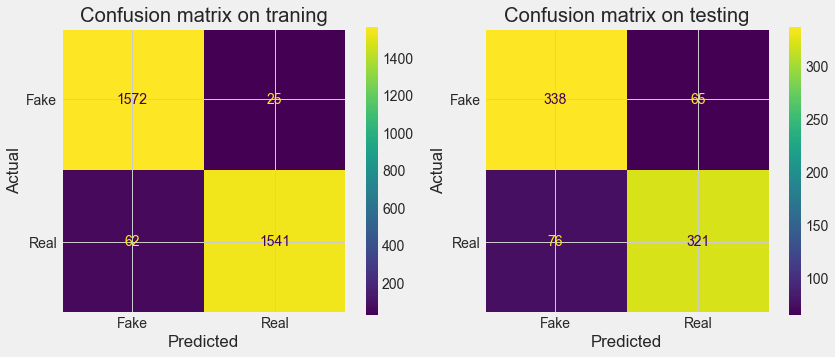

In [27]:
fig = plt.figure(figsize = (12,5))
layout = (1,2)

confusion_training = plt.subplot2grid(layout,(0,0))
confusion_test = plt.subplot2grid(layout,(0,1))

# Build a confusion matrix for label predictions in the training dataset
cm = confusion_matrix(y_trainn, y_train_predd)

# Build a display object that displays a confusion matrix with corresponding label names
cmd = ConfusionMatrixDisplay(cm, display_labels=['Fake','Real'])

# Plot a confusion matrix with titles and axis names
cmd.plot(ax = confusion_training)
cmd.ax_.set_title("Confusion matrix on traning")
cmd.ax_.set(xlabel='Predicted', ylabel='Actual')

# Build a confusion matrix for label predictions in the test dataset
cm = confusion_matrix(y_testt, y_test_predd)

# Build a display object that displays a confusion matrix with corresponding label names
cmd = ConfusionMatrixDisplay(cm, display_labels=['Fake','Real'])

# Plot a confusion matrix with titles and axis names
cmd.plot(ax = confusion_test)
cmd.ax_.set_title("Confusion matrix on testing")
cmd.ax_.set(xlabel='Predicted', ylabel='Actual')

# Show the Confusion Matrix
plt.tight_layout()
plt.savefig('Confusion matrix with tuning', dpi = 300)
plt.show()

## 6. Model Prediction

In [28]:
# Set a global variable to facilitate subsequent resize images
SIZE = 224

# Split data and labels into their own lists
# Declare a list for images4
images_test = []
# Declare a list for images label
labels_test = [] 

# loop for get the label (fake/real)
for directory_path in glob.glob(path + "real_and_fake_face/test/*"):
    
    # Get the image label
    label = directory_path.split("\\")[-1] 
    
    # Use for-loop to preprocess the images
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        
        # Load image from its file and specify load color image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  
        
        # Resize all photos to the same size  
        img = cv2.resize(img, (SIZE, SIZE)) 
        
        # Convert an image from one color space to another (from RGB to BGR)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
        
        # Normalization
        img = img / 255.0 
        
        # Add images and image tags to the corresponding lists
        images_test.append(img)
        labels_test.append(label) 

# Convert list to array     
images_test = np.array(images_test)
labels_test = np.array(labels_test)

In [29]:
print(images_test.shape)

(2041, 224, 224, 3)


In [30]:
# Fit and transform the labels at once
labels_encoded = le.transform(labels_test)

In [31]:
# Extract features from images (training dataset) using pretrained VGG16.
# VGG16 expects to rescale the color input image to the size of a 224×224 square
feature_extractor_test = VGG_model.predict(images_test)

# Reshape the extracted features of test data
test_features = feature_extractor_test.reshape(feature_extractor_test.shape[0], -1)
print(test_features.shape)

(2041, 25088)


In [32]:
###### Make predction on test ######
test_pred = best_model.predict(test_features)

# Inverse le transform to get original labels (fake or real)
# Because we trained the SVM on integer labels (0 or 1)
test_predd = le.inverse_transform(test_pred)
testt = le.inverse_transform(labels_encoded) 

In [33]:
# Generate the frame of actual and prediction result
pred = pd.DataFrame(test_predd)
actual = pd.DataFrame(testt)
result = pd.merge(pred, actual,  how='outer', left_index=True, right_index=True)
result.columns = ['Pred', 'Actual']

# Calculate each evaluation metric in test prediction
TP = result.Pred[(result['Actual'] == 'fake') & (result['Pred'] == 'fake')].count()
FN = result.Pred[(result['Actual'] == 'fake') & (result['Pred'] == 'real')].count()
FP = result.Pred[(result['Actual'] == 'real') & (result['Pred'] == 'fake')].count()
TN = result.Pred[(result['Actual'] == 'real') & (result['Pred'] == 'real')].count()

Accuracy = (TP + TN) / (TP + FP + TN + FN)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_score = (2 * Precision * Recall) / (Precision + Recall)

# Print the result
print('-----------------------------------------------------------------')
print('Predicting Test Set Results Using SVM Model With Tunning')
print('\tAccuracy: '+ str(Accuracy))
print('\tPrecision: ' + str(Precision))
print('\tRecall: ' + str(Recall))
print('\tF1 Score: ' + str(F1_score))

-----------------------------------------------------------------
Predicting Test Set Results Using SVM Model With Tunning
	Accuracy: 0.5291523762861342
	Precision: 0.4956521739130435
	Recall: 0.059375
	F1 Score: 0.10604651162790699


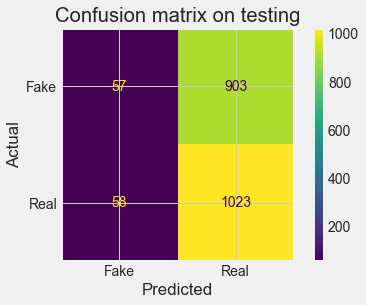

In [34]:
# Build a confusion matrix for label predictions in the test
cm = confusion_matrix(testt, test_predd)

# Build a display object that displays a confusion matrix with corresponding label names
cmd = ConfusionMatrixDisplay(cm, display_labels=['Fake','Real'])

# Plot a confusion matrix with titles and axis names
cmd.plot()
cmd.ax_.set_title("Confusion matrix on testing")
cmd.ax_.set(xlabel='Predicted', ylabel='Actual')

# Show the Confusion Matrix
plt.savefig('Confusion Matrix on Test set')
plt.show()